<a href="https://colab.research.google.com/github/jhasweta989/facial-expression-detection/blob/master/Facial_Expression_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all the necessary library


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.1


Plot some images from the dataset

In [ ]:
def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0

    for expression in os.listdir("/content/drive/MyDrive/facial expression/data/train/"):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img("/content/drive/MyDrive/facial expression/data/train/" + expression + "/" +os.listdir("/content/drive/MyDrive/facial expression/data/train/" + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

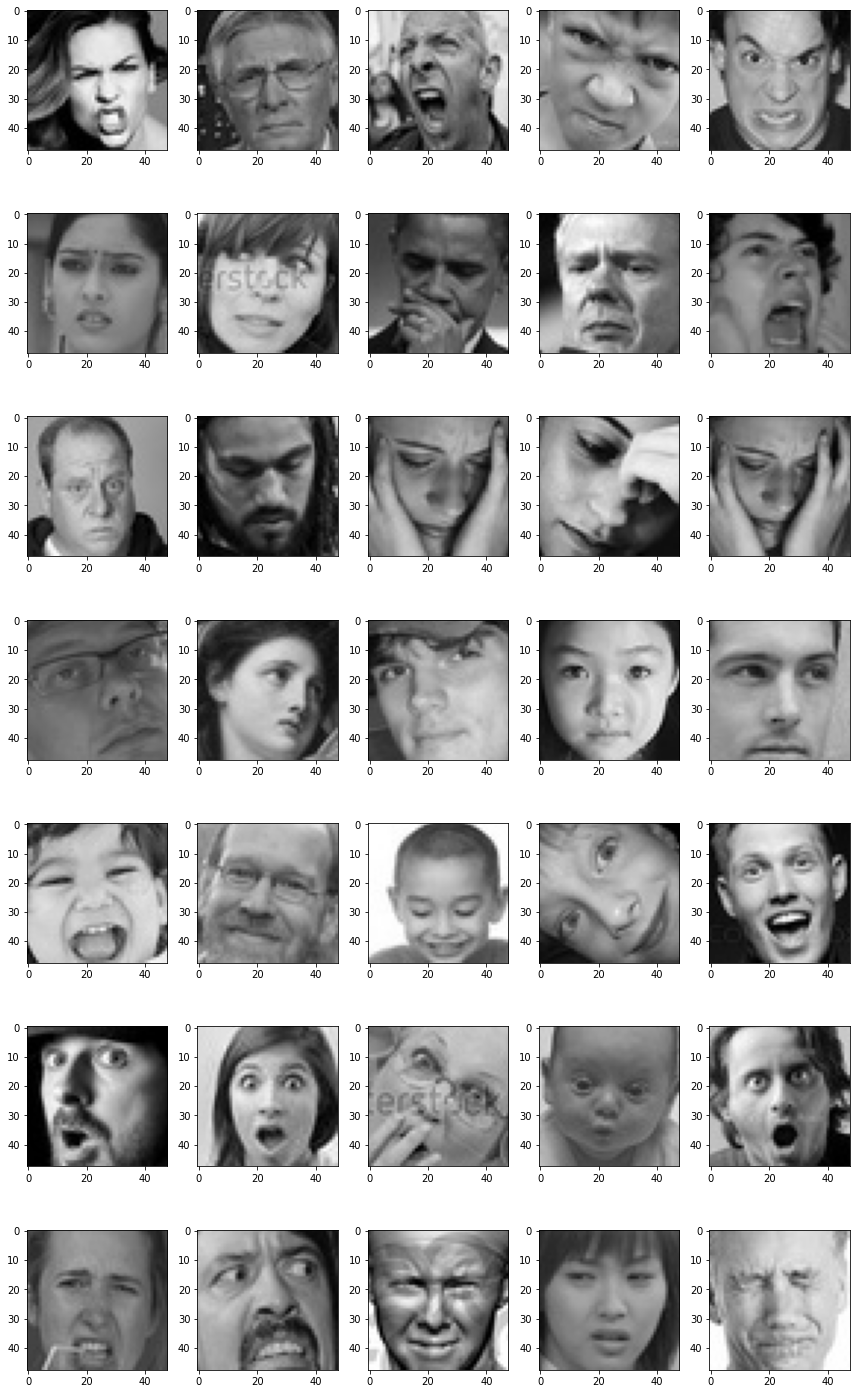

In [ ]:
plot_example_images(plt).show()

In [ ]:
for expression in os.listdir("/content/drive/MyDrive/facial expression/data/train/"):
    print(str(len(os.listdir("/content/drive/MyDrive/facial expression/data/train/" + expression))) + " " + expression + " images")

3995 angry images
4097 fear images
4830 sad images
4965 neutral images
7215 happy images
3171 surprise images
436 disgust images


split dataset for training and validation

In [ ]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("/content/drive/MyDrive/facial expression/data/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("/content/drive/MyDrive/facial expression/data/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model 

In [ ]:
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

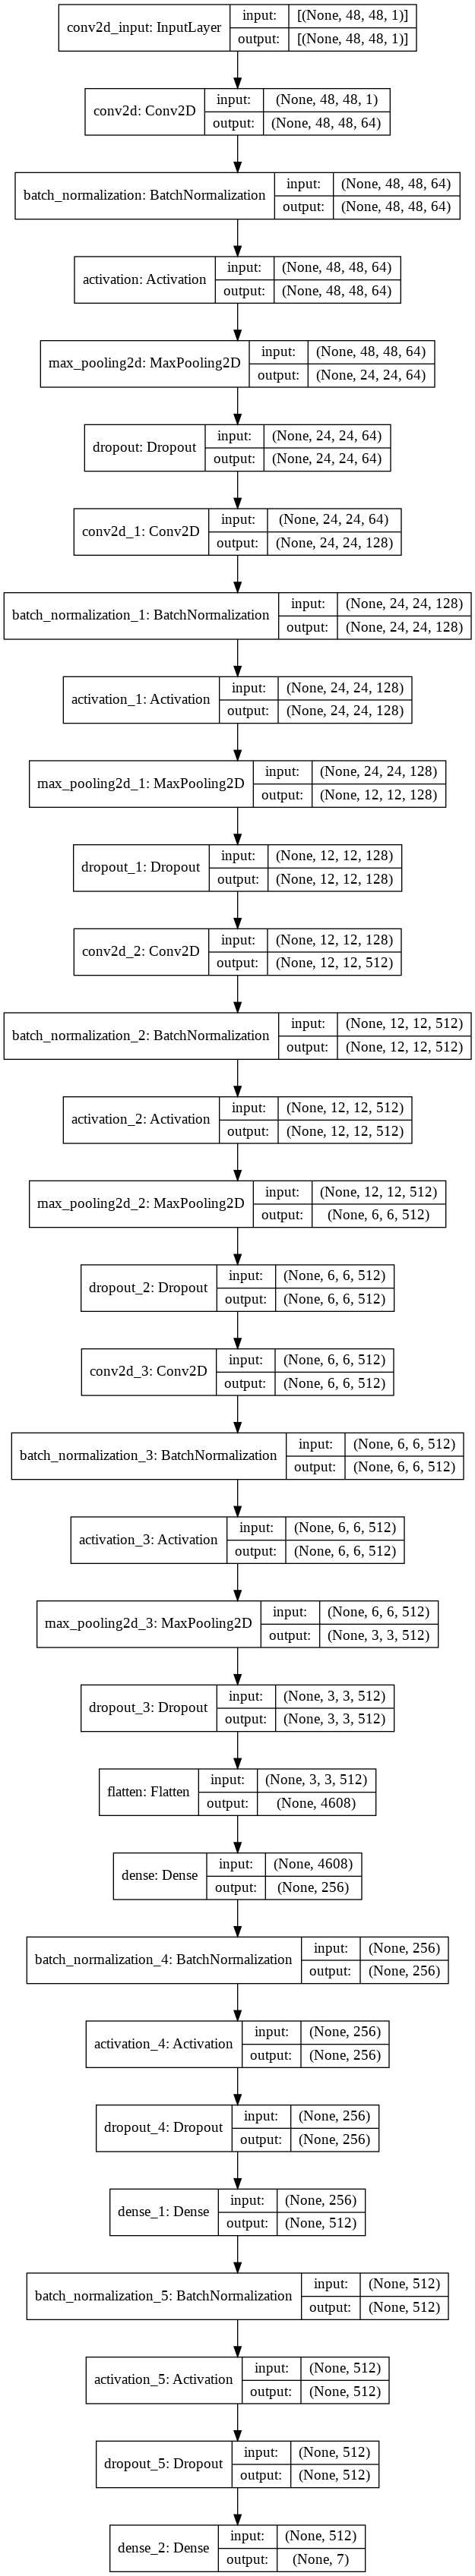

In [ ]:
import keras
keras.utils.plot_model(model,'/content/drive/MyDrive/facial expression/model.png',  show_shapes=True)


In [ ]:
import tensorflow as tf

training the model

In [ ]:

with tf.device('/GPU:0'):
        epochs = 15
        steps_per_epoch = train_generator.n//train_generator.batch_size
        validation_steps = validation_generator.n//validation_generator.batch_size

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=2, min_lr=0.00001, mode='auto')
        checkpoint = ModelCheckpoint("/content/drive/MyDrive/facial expression/face_model_weights.h5", monitor='val_accuracy',
                                    save_weights_only=True, mode='max', verbose=1)
        callbacks = [ checkpoint, reduce_lr]

        history = model.fit(
            x=train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data = validation_generator,
            validation_steps = validation_steps,
            callbacks=callbacks
        )

Epoch 1/15
448/448 [==============================] - 6280s 14s/step - loss: 1.9596 - accuracy: 0.2568 - val_loss: 1.5205 - val_accuracy: 0.4136

Epoch 00001: saving model to /content/drive/MyDrive/facial expression/face_model_weights.h5
Epoch 2/15
448/448 [==============================] - 43s 96ms/step - loss: 1.5125 - accuracy: 0.4210 - val_loss: 1.5629 - val_accuracy: 0.4295

Epoch 00002: saving model to /content/drive/MyDrive/facial expression/face_model_weights.h5
Epoch 3/15
448/448 [==============================] - 42s 93ms/step - loss: 1.3506 - accuracy: 0.4834 - val_loss: 1.3200 - val_accuracy: 0.5064

Epoch 00003: saving model to /content/drive/MyDrive/facial expression/face_model_weights.h5
Epoch 4/15
448/448 [==============================] - 41s 92ms/step - loss: 1.2552 - accuracy: 0.5188 - val_loss: 1.1997 - val_accuracy: 0.5371

Epoch 00004: saving model to /content/drive/MyDrive/facial expression/face_model_weights.h5
Epoch 5/15
448/448 [==============================]

save the model


In [ ]:

model_json = model.to_json()
with open("/content/drive/MyDrive/facial expression/model.json", "w") as json_file:
    json_file.write(model_json)